# 21.02 Decision Trees

Asking questions is a great way to get information about something you're trying to identify.  There are several classic games based on this process, like _20 Questions_, or _Guess Who_.  In these games you're usually asking question to a person.  You can also ask a question about a dataset.  Does an observation have this feature?  Is its value above a specific threshold?  Each question you ask gives you more information about the observation you're investigating.  This kind of process is the basis for a genre of models called **Decision Trees**.

### Learning from Questions

Using an abstract example to explain this concept further, say, you have users in eight different cities: San Francisco, Cairo, Beijing, Sidney, New Delhi, Chicago, and Johannesburg.  If you're trying to figure out where a user is, there are several questions you could ask to give you information about their location.  You could ask if they're in the northern or southern hemisphere, or if they're on a ocean or not.  Each answer can further refine the possible outcome, see the example below.

![Decision tree](decision_tree.png)

There is a bit of terminology to cover.   In the example above, each of the questions is a **node**.  Nodes are either root nodes (the first node), interior nodes (follow up questions), or leaf nodes (endpoints).  Every node except for leaf nodes contains a **rule**, which is the question being asked.  The links between nodes are called **branches** or **paths**.  When put in terms of flow, you start at the root node and follow branches through interior nodes until you arrive at a leaf node.  The whole thing would look much more like a tree of you turned it upside down so the root was at the bottom and the leaves and branches were higher up, but this is the conventional way to represent the tree. 

Each rule divides the data into a certain number of subgroups, typically two subgroups with binary "yes or no" questions being particularly common.  It is important to note that all data must have a way to flow through the tree, it cannot simply disappear or not be contained in the tree. 

Through a series of questions, you're able to gain information about where the user is, narrowing down the possible number of questions each time, ultimately arriving at an answer.

### Entropy

When designing a decision tree you want it to be as efficient as possible.  It's logical that not all questions consist of the same amount of information.  Using the example above, if you were to ask if they were in Norway, that would be a pretty useless question.  You gain no information from their answer.  Evaluating questions, or nodes, requires you to introduce two additional concepts from a field known as _information theory: information gain and entropy_.

Entropy is a term you may be familiar with from other disciplines, particularly the sciences, where it means disorder.  Here it will mean something along the lines of uncertainty.  It can be defined using _Shannon Entropy_ $H$, as: 

$$H = -\sum_{i=1}^n P(x_i) log_2 P(x_i)$$

This equation corresponds to the weighted sum of log base two of the probabilities of all outcomes.  The important thing to take away here is that this is a measure of uncertainty in the outcome.  As you limit the possible number of outcomes and become more confident in the outcome, the entropy decreases.  An area of the tree with only one possible outcome has zero entropy because there is no uncertainty.  To delve into the reason for the logarithmic term here would require a deeper dive into information theory that there is time for here.  If interested you can find an this primer on [Shannon Entropy](https://arxiv.org/pdf/1405.2061.pdf).

You can then use entropy to measure the information gain, defined as the change in entropy from the original state wo the weighted potential outcomes of the following state.  One method of designing an efficient decision tree is to gain the most information as quickly as possible.

### Coded example

Walk through an example of how this could be implemented in Python using SKLearn.  For this example, say, you're interested in whether a customer is likely to come back within 30 days.  Here you have a snapshot of your customer base from some moment more than thirty day in the past.  You have purchase amount, number of items purchased, if they used a promo on their purchase, if they're subscribed to our email list, and how many times they have made a purchase.  Since it's historical data, you also have a repeat variable for whether they were a repeat customer in the next thirty days from when this snapshot was taken.



In [2]:
import scipy

# Packages for rendering the tree 
import pydotplus 
import graphviz

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

# The model the example uses
from sklearn import tree 

# Convenience for displaying visualizations
from IPython.display import Image

In [3]:
# Set up all the data in a couple of data frames.
customers = pd.DataFrame()
customers['purchases_amount'] = [105, 65, 89, 99, 149, 102, 34, 120, 129, 39,
                                 20, 30, 109, 40, 55, 100, 23, 20, 70, 10]
customers['purchases_items'] = [1, 4, 5, 4, 7, 1, 2, 10, 6, 5,
                                1, 3, 2, 1, 5, 10, 3, 3, 1, 1]
customers['promo'] = [1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
                      1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
customers['email_list'] = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
                           0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
customers['checkouts'] = [1, 5, 3, 3, 1, 2, 4, 4, 1, 1,
                          1, 1, 2, 4, 1, 1, 2, 1, 1, 1]

repeat_customer = pd.DataFrame()
repeat_customer['repeat'] = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                             0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

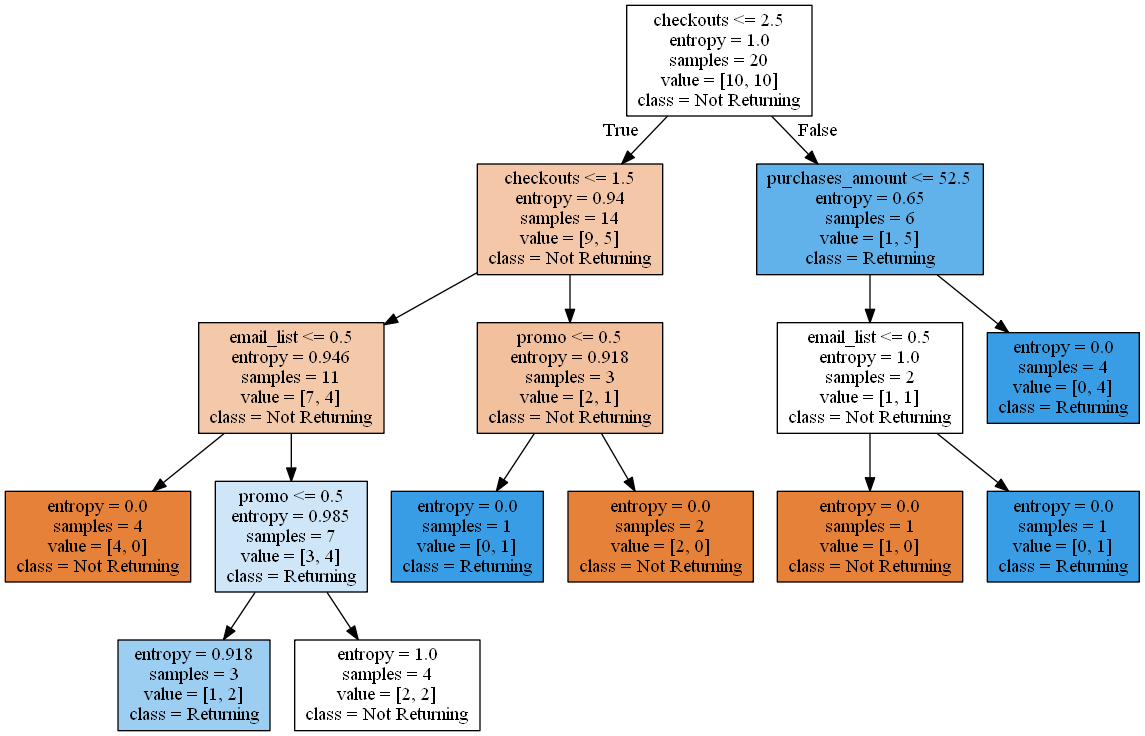

In [4]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=4,
    random_state=1337
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Above, you have a visualization of the trained tree.  For every note it shows the rule being applied, the entropy in the dataset (1 being the most uncertain, 0 being total certain), the samples remaining, the distribution of those samples, and the dominant class.

You can also follow trees.  As you move down a tree to the left you are meeting the rule, to the right you are outside of the rule.  Son in the branches below the root node, all nodes to the left have a `checkouts` value less than or equal to `2.5` and all the nodes to the right have a `checkouts` value that isn’t_ less than or equal to `2.5`.  You can follow this all the way down the tree, and the same is true for each new rule introduced at each node.  

Note the parameters that were set when the tree was initialized.  First, you want to use entropy to build the tree (`criterion=entropy`), which follows the method discussed above of looking for information gain.  The `max_features` was set to `1`, meaning only one feature will be used per node.  The `max_depth` of the tree was set to `4`, which means that there are only four decision levels below the root of the classification. 

There is something in this example that you wouldn't ever do when using decision trees for real: the `random_state` was set to an arbitrary integer (1337).  This classifier works by repeatedly splitting the training data randomly, which can lead to inconsistent trees.  Setting the random seed so the tree looks a specific way for this assignment, but you wouldn't do that when actually using this model.

### Why Decision Trees?

There are several reasons someone would want to use a decision tree.  Some of the benefits include: 
- Easy to represent the model visually 
- Can handle varied types of data 
- Feature selection is part of the model 
- Easy to use with little data preparation

However, there are some key downsides to be aware of.  First, there is a randomness to their generation, which can lead to variance in estimates.  There is not a hard and fast rule to how the tree is built, so **it doesn't build the same way every time**.  You see the because of the `random_state` argument.  In addition, **they are incredibly prone to overfitting**, particularly if you allow them to grow too deep or complex.  Also note that because they are working from information gain, they are biased towards the dominant class, so **balanced data is needed**.  This time the decision tree was a classifier, but they can also be used for regression, which will be covered soon.


### Tinker

Spend a few minutes tinkering with this example and the arguments you pass into the model above. Remove the `random_state` argument and re-generate the tree a few times to see how random splitting changes your result. Change your `max_depth` to see how that affects things. Make sure you fully understand what each parameter does and what the tradeoffs are.

#### Remove `random_state` Argument

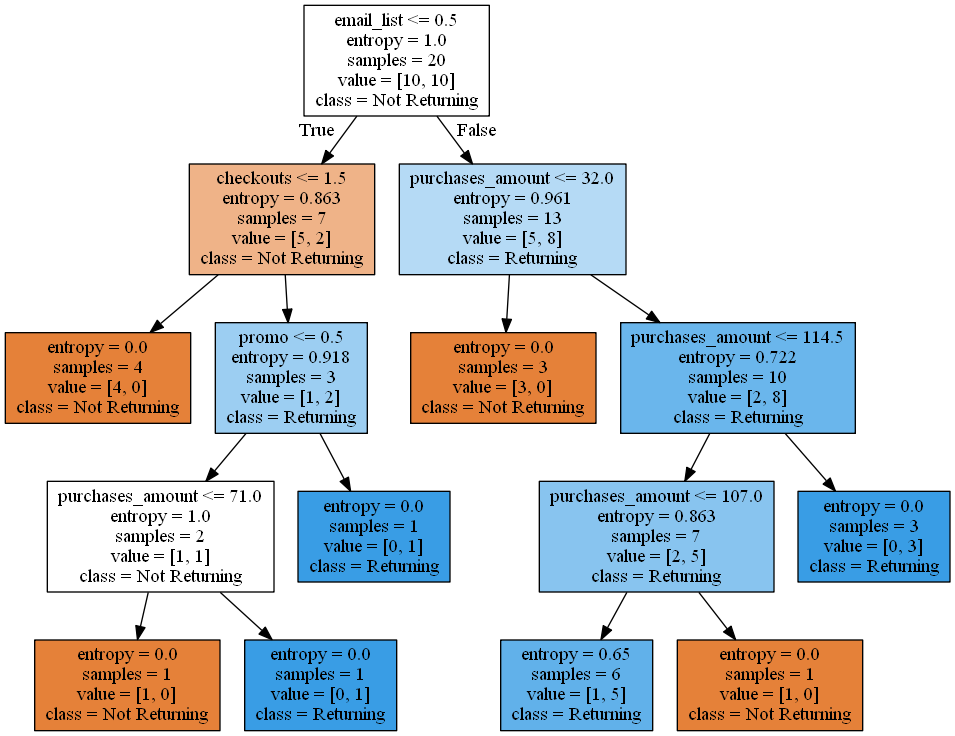

In [4]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=4
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

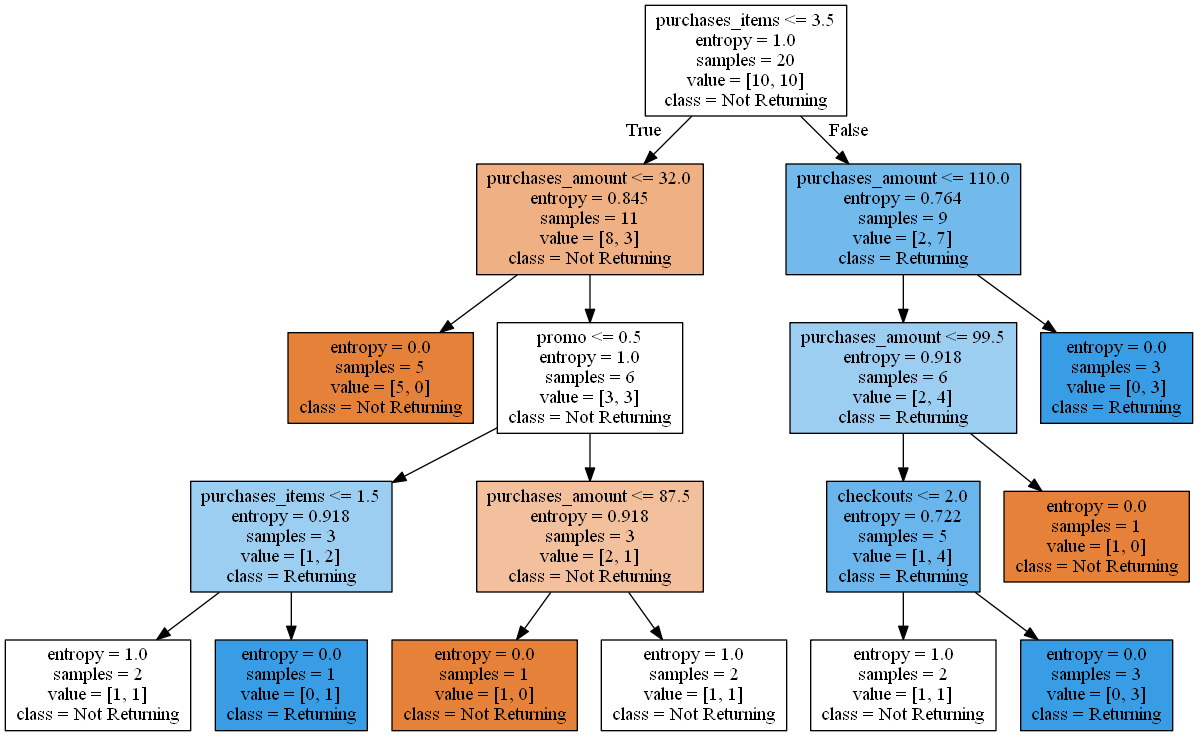

In [5]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=4
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

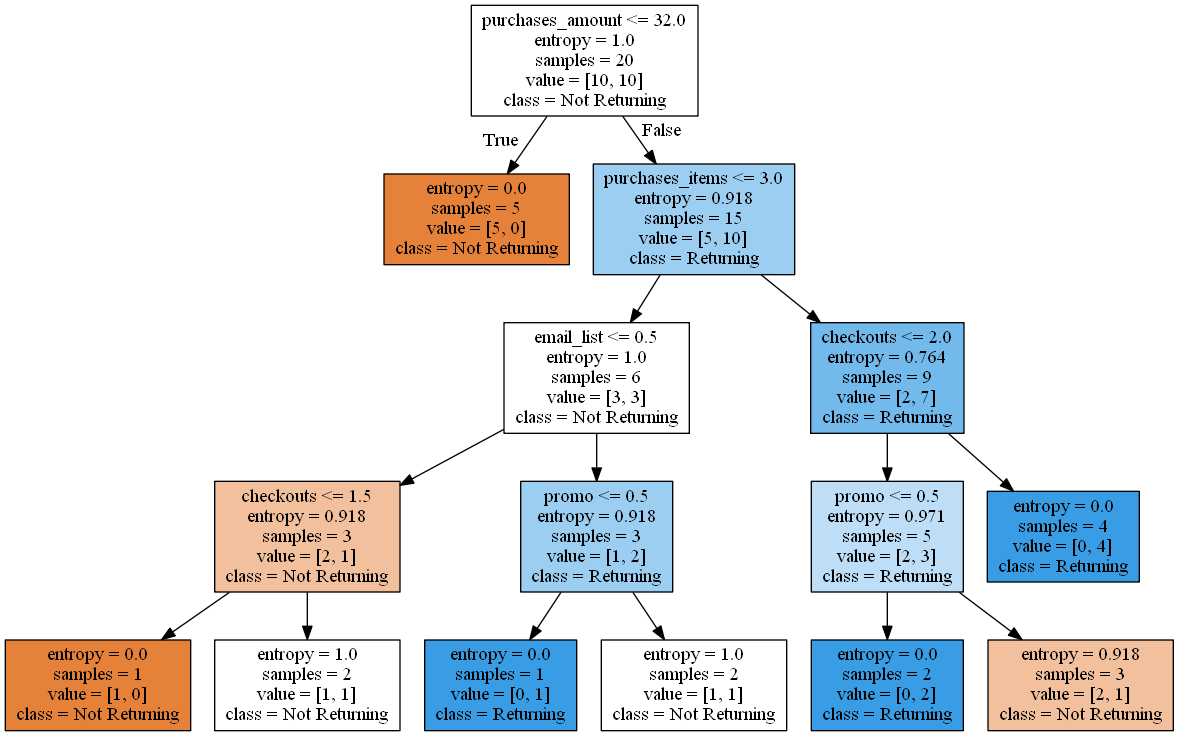

In [6]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=4
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Change `max_depth` setting

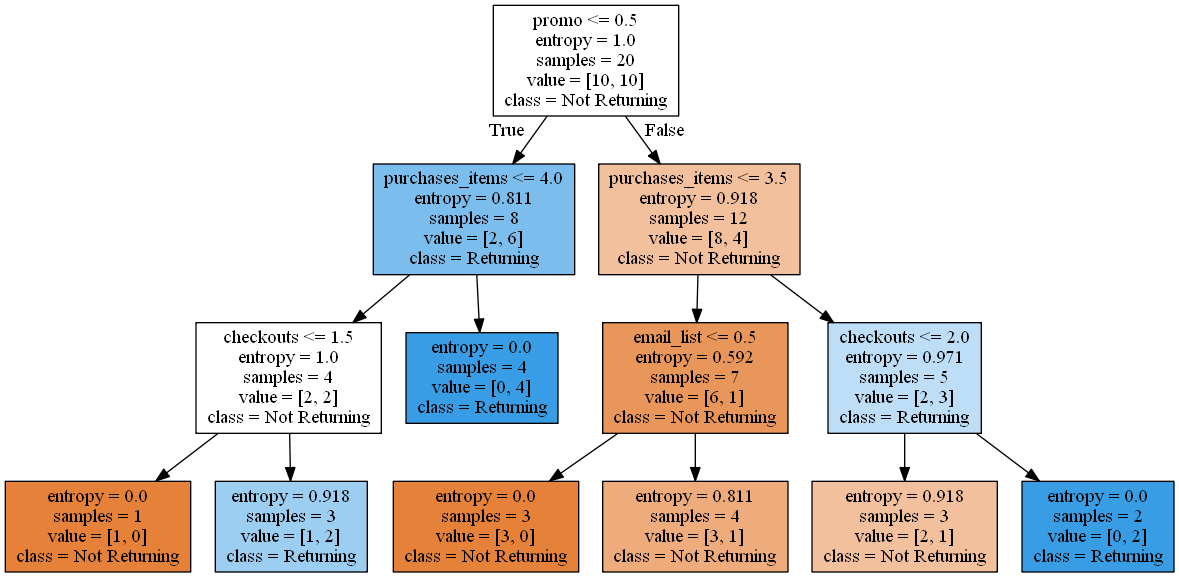

In [7]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=3
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

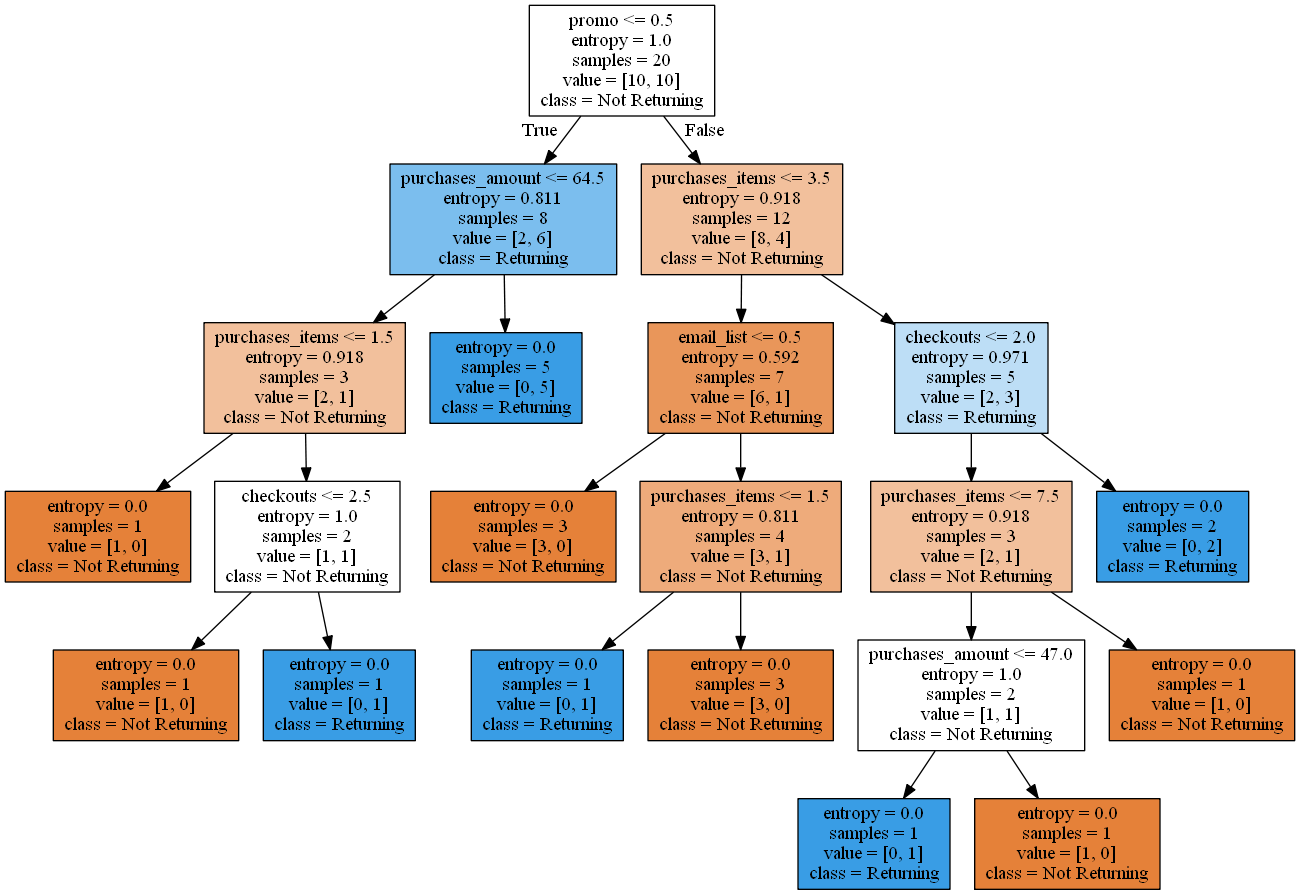

In [8]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion="entropy", 
    max_features=1,
    max_depth=5
)

decision_tree.fit(customers, repeat_customer)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, 
    out_file=None, 
    feature_names=customers.columns, 
    class_names=["Not Returning", "Returning"], 
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())